In [1]:
from typing import Literal
from numpy import (
    exp,
    pi,
    array,
    linspace,
    mean,
    delete,
    piecewise,
    outer,
    diag,
    sqrt,
    append,
    ndarray,
    round,
    asarray,
    where,
    isfinite,
    floor,
    abs,
    log10,
)
import pandas as pd
from datetime import datetime
import scipy.optimize
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from itertools import product
from typing import List, Tuple

plt.rcParams['text.usetex'] = False

def signif(x, p = 3):
    x = asarray(x)
    x_positive = where(isfinite(x) & (x != 0), abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - floor(log10(x_positive)))
    return round(x * mags) / mags

def correlation_from_covariance(covariance):
    v = sqrt(diag(covariance))
    outer_v = outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


normalize = lambda x: (x - x.min()) / (x.max() - x.min())

L = 3.5

@dataclass
class T_params:
    v: float
    chi: float
    T_heat_production_per_time: float
    bc: List[Tuple[int, float]] # bounary condition is in the form of (z, T)
    note: str
    L: float = field(default=L)

    def __post_init__(self):
        self.Pe = self.v * self.L / self.chi
        # Notice that meaning of S is different from previous code
        self.S = self.L**2 * self.T_heat_production_per_time / self.chi
        # self.R = self.Pe * self.S
        self.bc1, self.bc2 = self.bc
        self.z1, self.T1 = self.bc1
        self.z2, self.T2 = self.bc2
        self.d = 1.5/5

        self.q_func = lambda z: piecewise(z, [z < self.d, z >= self.d], [1, 0])

        # Calculate C4 (originally D)
        # D = (u_2 - u_1 - S_hat/(Pe^2 * e^(Pe*xi_0)) * (e^(Pe*xi_0) - e^(Pe*z_1)) + S_hat/Pe * (xi_0 - z_2)) / (e^(Pe*z_2) - e^(Pe*z_1))
        # Using new variable names: C4 = (T2 - T1 - S/(Pe**2 * exp(Pe * d)) * (exp(Pe * d) - exp(Pe * z1)) + S/Pe * (d - z2)) / (exp(Pe * z2) - exp(Pe * z1))
        self.C4 = (self.T2 - self.T1 - self.S / (self.Pe**2 * exp(self.Pe * self.d)) * (exp(self.Pe * self.d) - exp(self.Pe * self.z1)) + self.S / self.Pe * (self.d - self.z2)) / (exp(self.Pe * self.z2) - exp(self.Pe * self.z1))


        # Calculate C2 (originally B)
        # B = D + S_hat / (Pe^2 * e^(Pe*xi_0))
        # Using new variable names: C2 = C4 + S / (Pe**2 * exp(Pe * d))
        self.C2 = self.C4 + self.S / (self.Pe**2 * exp(self.Pe * self.d))

        # Calculate C1 (originally A)
        # A = u_1 - (D + S_hat / (Pe^2 * e^(Pe*xi_0))) * e^(Pe*z_1)
        # Using new variable names: C1 = T1 - (C4 + S / (Pe**2 * exp(Pe * d))) * exp(Pe * z1)
        self.C1 = self.T1 - (self.C4 + self.S / (self.Pe**2 * exp(self.Pe * self.d))) * exp(self.Pe * self.z1)

        # Calculate C3 (originally C)
        # C = u_1 - D * e^(Pe*z_1) + S_hat / (Pe^2 * e^(Pe*xi_0)) * (e^(Pe*xi_0) - e^(Pe*z_1)) - S_hat/Pe * xi_0
        # Using new variable names: C3 = T1 - C4 * exp(Pe * z1) + S / (Pe**2 * exp(Pe * d)) * (exp(Pe * d) - exp(Pe * z1)) - S/Pe * d
        self.C3 = self.T1 - self.C4 * exp(self.Pe * self.z1) + self.S / (self.Pe**2 * exp(self.Pe * self.d)) * (exp(self.Pe * self.d) - exp(self.Pe * self.z1)) - self.S / self.Pe * self.d

    def formula(self):
        return f"({signif(self.C1)} + {signif(self.C2)} * exp({signif(self.Pe)} * z)) * q_func(z) + ({signif(self.C3)} + {signif(self.C4)} * exp({signif(self.Pe)} * z) + {signif(self.S)} / {signif(self.Pe)} * z) * (1 - q_func(z))"

def T_func(zdata, params: T_params):
    z = zdata
    # return piecewise(z, [z < params.d, z >= params.d], [params.C1 + params.C2 * exp(params.Pe * z), params.C3 + params.C4 * exp(params.Pe * z) + params.S/params.Pe*z])
    # print(params.C1, params.C2, params.Pe, z)
    # print(params.q_func(z))
    return (params.C1 + params.C2 * exp(params.Pe * z)) * params.q_func(z) +  (params.C3 + params.C4 * exp(params.Pe * z) + params.S/params.Pe*z)*(1-params.q_func(z))

num_regions = 17
note_dict: dict[str, Literal["remove process tank", "invalid tank bottom", "no heat production"]] = {}
for i in range(1, num_regions + 1):
    match i:
        case 1 | 2:
            note_dict.update({str(i): "remove process tank"})
        case 12 | 15:
            note_dict.update({str(i): "no heat production"})
        case _:
            note_dict.update({str(i): "invalid tank bottom"})

@dataclass
class Data:
    yTs: ndarray
    yTs_mean: ndarray
    v: ndarray
    z: ndarray
    x: ndarray
    t_min: float
    t_max: float
    flow_rate_from_absorber: float
    flow_rate_to_absorber: float
    # absorber_process_tank_level: ndarray
    # desorber_process_tank_level: ndarray
    x1: float = field(init=False)
    x2: float = field(init=False)
    z1: float = field(init=False)
    z2: float = field(init=False)
    T1: float = field(init=False)
    T2: float = field(init=False)

    # Constants
    L: float = field(default=L)
    r_pack: float = field(default=0.18) # inner radius of the pack
    h_pack: float = field(default=2)       # height of the pack
    rho: float = field(default=997)    # NOTE USE WATER DENSITY
    cp: float = field(default=4184)        # NOTE USE WATER SPECIFIC HEAT CAPACITY
    porosity: float = field(default=0.97)
    V_pack: float = field(init=False)    # Volume of the pack
    V_void: float = field(init=False)    # Volume of the pack void, or volume of liquid in the pack
    m: float = field(init=False)    # Mass of the liquid in the pack

    def __post_init__(self):
        self.V_pack = pi * self.r_pack**2 * self.h_pack
        self.V_void = self.V_pack * self.porosity
        self.V_solvent = self.V_void * 0.04
        self.m = self.rho * self.V_solvent

    @classmethod
    def from_df(
        cls, df: pd.DataFrame, note: Literal["remove process tank", "invalid tank bottom", "no heat production"] = None
    ):
        # absorber_process_tank_level = df["A010_BL01 - [m]"]
        # desorber_process_tank_level = df["A050_BL01 - [m]"]

        yTs = array([df[f"yT{i}"] for i in range(6)])  # shape (6, ?)
        time = array([datetime.strptime(ts, "%Y/%m/%d %H:%M:%S") for ts in df.time])
        yTs_mean = mean(yTs, axis=1)
        flow_rate_from_absorber = mean(df["A010_BF01 - [m³/h]"])
        flow_rate_to_absorber = mean(df["A010_BF02 - [m³/h]"])

        match note:
            case "remove process tank":
                # Now we have (tank bottom, pack bottom, pack mid, pack top, gas outlet)
                # Then there is x = (1,2,3,4) but z = (0.2, 0.4, 0.6, 0.8), relation is x = 5z
                cls.x1, cls.x2 = 1, 4                   # boundary x
                cls.z1, cls.z2 = cls.x1/5, cls.x2/5     # boundary z
                cls.T1, cls.T2 = yTs_mean[cls.x1], yTs_mean[cls.x2]
                yTs = delete(yTs, [0, 5], axis=0)
                yTs_mean = delete(yTs_mean, [0, 5], axis=0)
                x = array([1, 2, 3, 4])
                z = array([0.2, 0.4, 0.6, 0.8])

            case "invalid tank bottom" | "no heat production":
                # Now we have (process tank, pack bottom, pack mid, pack top, gas outlet)
                # Then there is x = (0,2,3,4) but z = (0,0.4,0.6,0.8), relation is x = 5z
                cls.x1, cls.x2 = 0, 4                   # boundary x
                cls.z1, cls.z2 = cls.x1/5, cls.x2/5     # boundary z
                cls.T1, cls.T2 = yTs_mean[cls.x1], yTs_mean[cls.x2]
                yTs = delete(yTs, [1, 5], axis=0)
                yTs_mean = delete(yTs_mean, [1, 5] , axis=0)
                x = array([0, 2, 3, 4])  # updated x values
                z = array([0, 0.4, 0.6, 0.8])  # updated z values
                
            case _:
                raise ValueError(f"Invalid note: {note}")

        # v = -5e-2
        # v = -2.73e-3 * flow_rate_from_absorber  # data from DTI
        # v = -1e-1 * flow_rate_from_absorber
        v = -1e-2 * flow_rate_from_absorber
        # v = -1e-3 * flow_rate_from_absorber
        # v = -1.0 * flow_rate_from_absorber
        
        
        return cls(
            yTs=yTs,
            yTs_mean=yTs_mean,
            v=v,
            z=z,
            x=x,
            t_min=time.min(),
            t_max=time.max(),
            flow_rate_from_absorber=flow_rate_from_absorber,
            flow_rate_to_absorber=flow_rate_to_absorber,
            # absorber_process_tank_level=absorber_process_tank_level,
            # desorber_process_tank_level=desorber_process_tank_level,
        )

num = 500
# df = pd.read_csv(rf"csv/df complete 1.csv")
# data = Data.from_df(df, note="invalid tank bottom")

In [2]:
# Some helper functions
def flatten_array(arr):
    return arr.tolist() if hasattr(arr, 'tolist') else arr

def data_list_to_df_verbose(data_list):
    records = []
    for data in data_list:
        record = {
            "t_min": data.t_min,
            "t_max": data.t_max,
            "flow_rate_from_absorber": data.flow_rate_from_absorber,
            "flow_rate_to_absorber": data.flow_rate_to_absorber,
            "x1": data.x1,
            "x2": data.x2,
            "z1": data.z1,
            "z2": data.z2,
            "T1": data.T1,
            "T2": data.T2,
            "v": data.v,
            "V_pack": data.V_pack,
            "V_void": data.V_void,
            "m": data.m,
            "L": data.L,
            "r_pack": data.r_pack,
            "h_pack": data.h_pack,
            "rho": data.rho,
            "cp": data.cp,
            "porosity": data.porosity,
            "yTs": flatten_array(data.yTs),
            "yTs_mean": flatten_array(data.yTs_mean),
            "x": flatten_array(data.x),
            "z": flatten_array(data.z),
        }
        records.append(record)
    return pd.DataFrame(records)

fit on xdata [[-0.03905349 -0.03905349 -0.03905349 -0.03905349 -0.03918466 -0.03918466
  -0.03918466 -0.03918466]
 [ 0.          0.4         0.6         0.8         0.          0.4
   0.6         0.8       ]],
 ydata [30.69333829 29.83682052 29.74234414 29.62026266 30.8817785  30.10717683
 30.04258574 29.94919121]

chi_eff, C1, C2 = [ 0.03689699 29.74992247  1.03688234]
cov = [[ 0.00075114 -0.00562994  0.00514285]
 [-0.00562994  0.04934665 -0.04784439]
 [ 0.00514285 -0.04784439  0.0620469 ]]


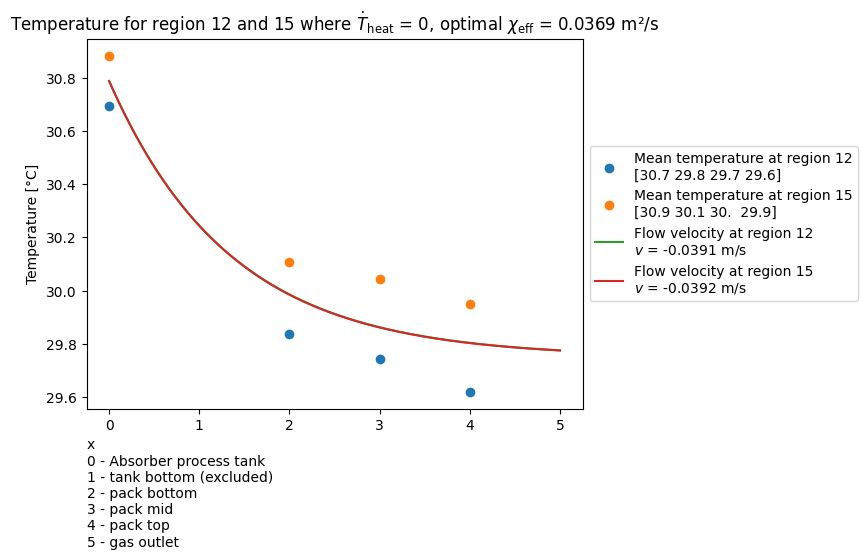

In [3]:
def T_find_chi_eff_func(vzdata, chi_eff, C1, C2):
    """
    No heat production in these case
    """
    v,z = vzdata
    return C1 + C2 * exp(v * z * L / chi_eff)

xlinspace = linspace(0, 5, num)
zlinspace = linspace(0, 1, num)

xlabel = "x\n0 - Absorber process tank\n1 - tank bottom (excluded)\n2 - pack bottom\n3 - pack mid\n4 - pack top\n5 - gas outlet"

find_chi_eff_regions = [str(i) for i in [12, 15]]
v_list = array([])  # v = v
T_list = array([])
for region in find_chi_eff_regions:
    df = pd.read_csv(rf"csv/df complete {region}.csv")
    data = Data.from_df(df, note="invalid tank bottom")
    T_list = append(T_list, data.yTs_mean)
    v_list = append(v_list, data.v)

    plt.plot(
        data.x, data.yTs_mean, "o", label=f"Mean temperature at region {region}\n{signif(data.yTs_mean)}"
    )

    # plt.violinplot(data.yTs.tolist(), positions=data.x)
    plt.legend()

xdata = array(list(product(v_list, data.z))).T
ydata = T_list
print(f"fit on xdata {xdata},\n ydata {ydata}")
print()

params, pcov, *args = scipy.optimize.curve_fit(
    T_find_chi_eff_func, 
    xdata, 
    ydata, 
    check_finite=True, 
    full_output=True, 
)

print(f"chi_eff, C1, C2 = {params}")
print(f"cov = {pcov}")

chi_eff = params[0]

# T and x
for i in range(len(v_list)):
    plt.plot(
        xlinspace,
        T_find_chi_eff_func([v_list[i], zlinspace], *params),
        label=f"Flow velocity at region {find_chi_eff_regions[i]}\n$v$ = {signif(v_list[i])} m/s",
    )
plt.xlabel(
    xlabel,
    loc="left",
)
plt.ylabel("Temperature [°C]")
plt.title(f"Temperature for region 12 and 15 where $\\dot{{T}}_{{\\text{{heat}}}}$ = 0, optimal $\\chi_{{\\text{{eff}}}}$ = {signif(chi_eff)} m²/s")
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
# plt.show()

# larger size figure
# plt.figure(figsize=(16, 9))
plt.savefig("T_no_heat.svg", bbox_inches="tight")
plt.savefig("T_no_heat.pdf", bbox_inches="tight")

In [5]:
def flux_func(z, params: T_params):
    """
    This is J_star.
    J_star(z) = Pe*T - dT/dz
    J(z) = chi/L * J_star(z)
    """
    return (params.Pe * (params.C1 + params.C2 * exp(params.Pe * z)) - params.C2 * params.Pe * exp(params.Pe * z)) * params.q_func(z) +  (params.Pe * (params.C3 + params.C4 * exp(params.Pe * z) + params.S/params.Pe*z) - (params.C4 * params.Pe * exp(params.Pe * z) + params.S/params.Pe))*(1-params.q_func(z))

7 -52.9
11 -1500.0
13 -2500.0
14 -1960.0
16 -2170.0
17 -1880.0


,t_min,t_max,flow_rate_from_absorber,flow_rate_to_absorber,x1,x2,z1,z2,T1,T2,...,L,r_pack,h_pack,rho,cp,porosity,yTs,yTs_mean,x,z
0,2024-05-27 17:00:17,2024-05-28 08:19:44,9.379462,8.695371,0,4,0.0,0.8,46.396713,46.404577,...,3.5,0.18,2,997,4184,0.97,"[[43.928077, 43.666322, 43.853511, 43.816485, ...","[43.453275967601016, 45.97922044521296, 45.726...","[1, 2, 3, 4]","[0.2, 0.4, 0.6, 0.8]"
1,2024-05-28 10:30:01,2024-05-28 12:59:56,9.275512,8.591834,0,4,0.0,0.8,46.396713,46.404577,...,3.5,0.18,2,997,4184,0.97,"[[33.477606, 33.778165, 34.104565, 33.864849, ...","[33.35518828888888, 31.70729226444444, 30.6900...","[1, 2, 3, 4]","[0.2, 0.4, 0.6, 0.8]"
2,2024-05-28 17:00:15,2024-05-29 06:59:47,8.898897,8.729493,0,4,0.0,0.8,46.396713,46.404577,...,3.5,0.18,2,997,4184,0.97,"[[45.500004, 45.520554, 45.540794, 45.550934, ...","[45.65055140565286, 45.0002511950637, 44.98969...","[0, 2, 3, 4]","[0.0, 0.4, 0.6, 0.8]"
3,2024-05-29 11:00:04,2024-05-29 13:47:43,9.132061,8.666075,0,4,0.0,0.8,46.396713,46.404577,...,3.5,0.18,2,997,4184,0.97,"[[30.295429, 30.274885, 30.244213, 30.213839, ...","[30.740791618290256, 30.30441852087475, 30.331...","[0, 2, 3, 4]","[0.0, 0.4, 0.6, 0.8]"
4,2024-05-29 14:00:05,2024-05-29 15:14:53,4.790606,4.332533,0,4,0.0,0.8,46.396713,46.404577,...,3.5,0.18,2,997,4184,0.97,"[[30.868633, 30.878769, 30.888897, 30.899025, ...","[31.294694079999996, 31.111844111111107, 30.66...","[0, 2, 3, 4]","[0.0, 0.4, 0.6, 0.8]"
5,2024-05-29 15:22:13,2024-05-29 21:59:56,9.118254,8.657270,0,4,0.0,0.8,46.396713,46.404577,...,3.5,0.18,2,997,4184,0.97,"[[31.289366, 31.309622, 31.329878, 31.32987, 3...","[30.65666110654362, 30.08420532214765, 30.1927...","[0, 2, 3, 4]","[0.0, 0.4, 0.6, 0.8]"
6,2024-05-30 00:00:12,2024-05-30 08:59:53,9.204919,8.726812,0,4,0.0,0.8,46.396713,46.404577,...,3.5,0.18,2,997,4184,0.97,"[[45.62529, 45.574352, 45.533867, 45.533867, 4...","[45.77492492764379, 44.97530836054422, 45.1381...","[0, 2, 3, 4]","[0.0, 0.4, 0.6, 0.8]"
7,2024-06-25 23:05:10,2024-06-26 08:19:56,4.542637,4.315505,0,4,0.0,0.8,46.396713,46.404577,...,3.5,0.18,2,997,4184,0.97,"[[30.574375, 30.574375, 30.574375, 30.594629, ...","[30.595422960217, 30.15945788426763, 30.089042...","[0, 2, 3, 4]","[0.0, 0.4, 0.6, 0.8]"
8,2024-06-26 17:00:07,2024-06-27 21:20:45,9.228229,8.754378,0,4,0.0,0.8,46.396713,46.404577,...,3.5,0.18,2,997,4184,0.97,"[[45.981476, 46.001999, 46.001999, 45.981754, ...","[45.96502044735288, 45.54778241645345, 45.3420...","[0, 2, 3, 4]","[0.0, 0.4, 0.6, 0.8]"
9,2024-06-27 23:00:15,2024-06-28 11:39:41,9.115219,8.645112,0,4,0.0,0.8,46.396713,46.404577,...,3.5,0.18,2,997,4184,0.97,"[[30.633965, 30.644093, 30.654224, 30.644094, ...","[30.871339213562308, 30.65406985248789, 30.346...","[0, 2, 3, 4]","[0.0, 0.4, 0.6, 0.8]"


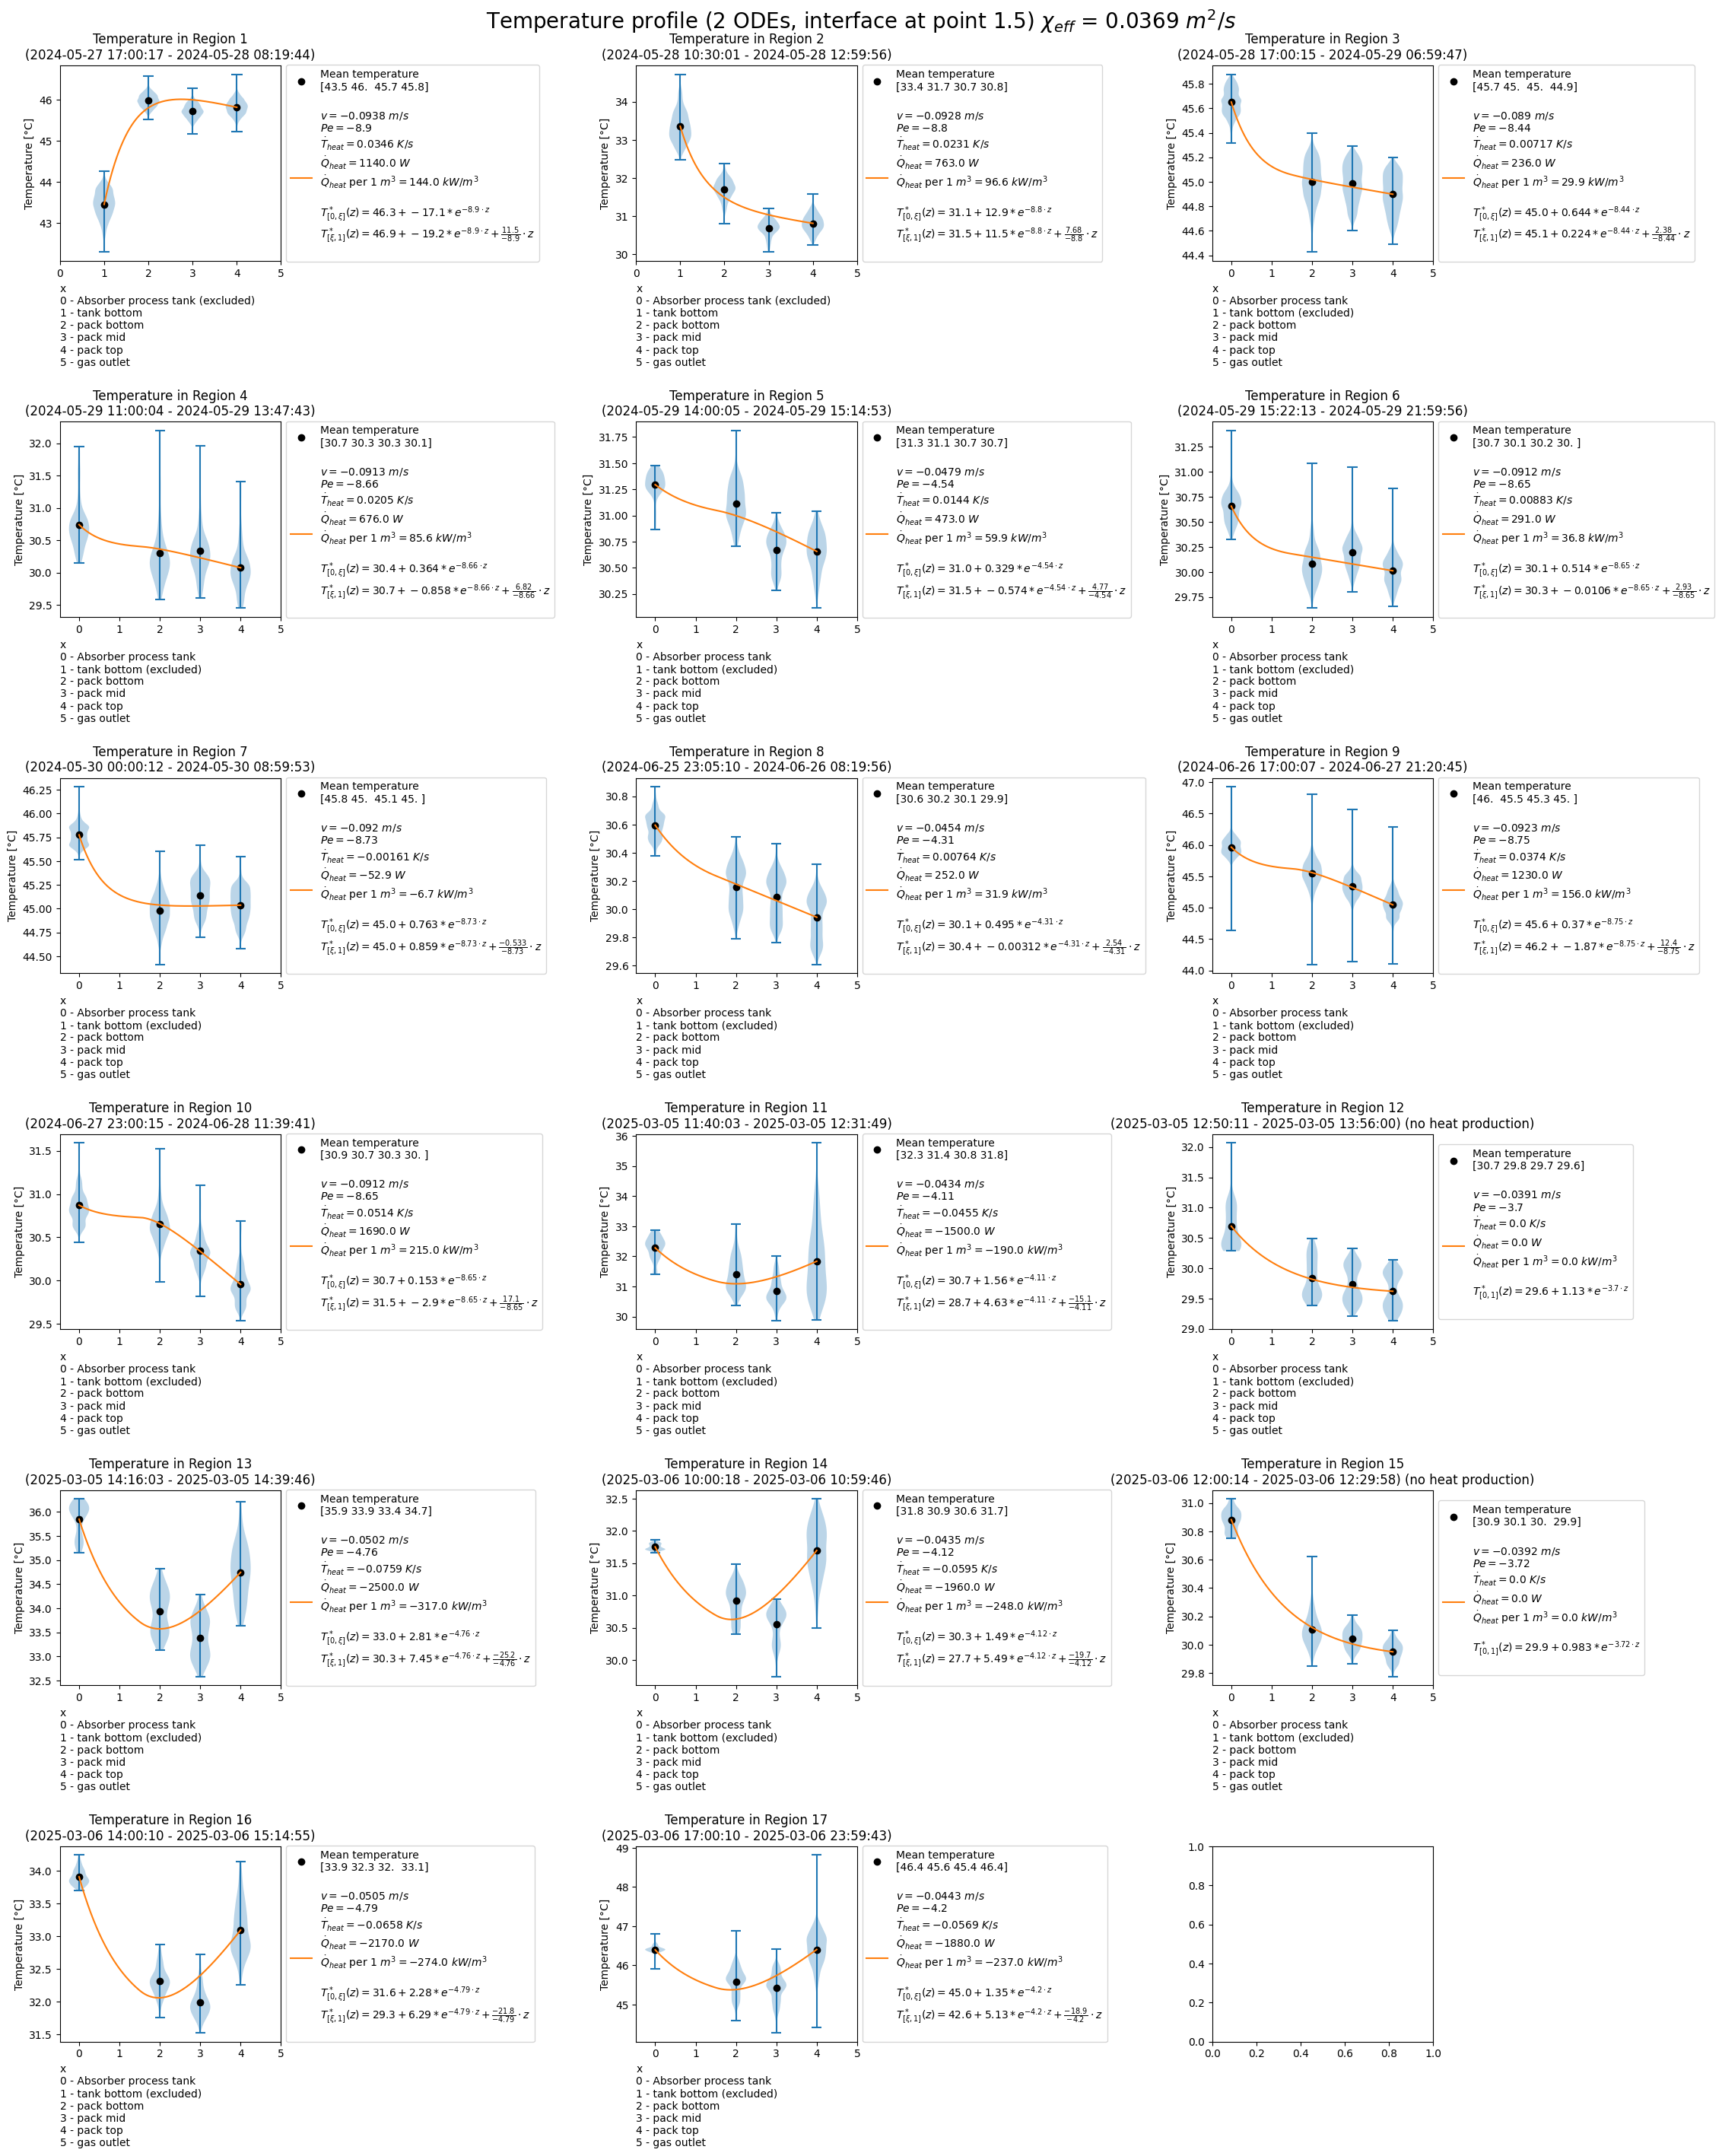

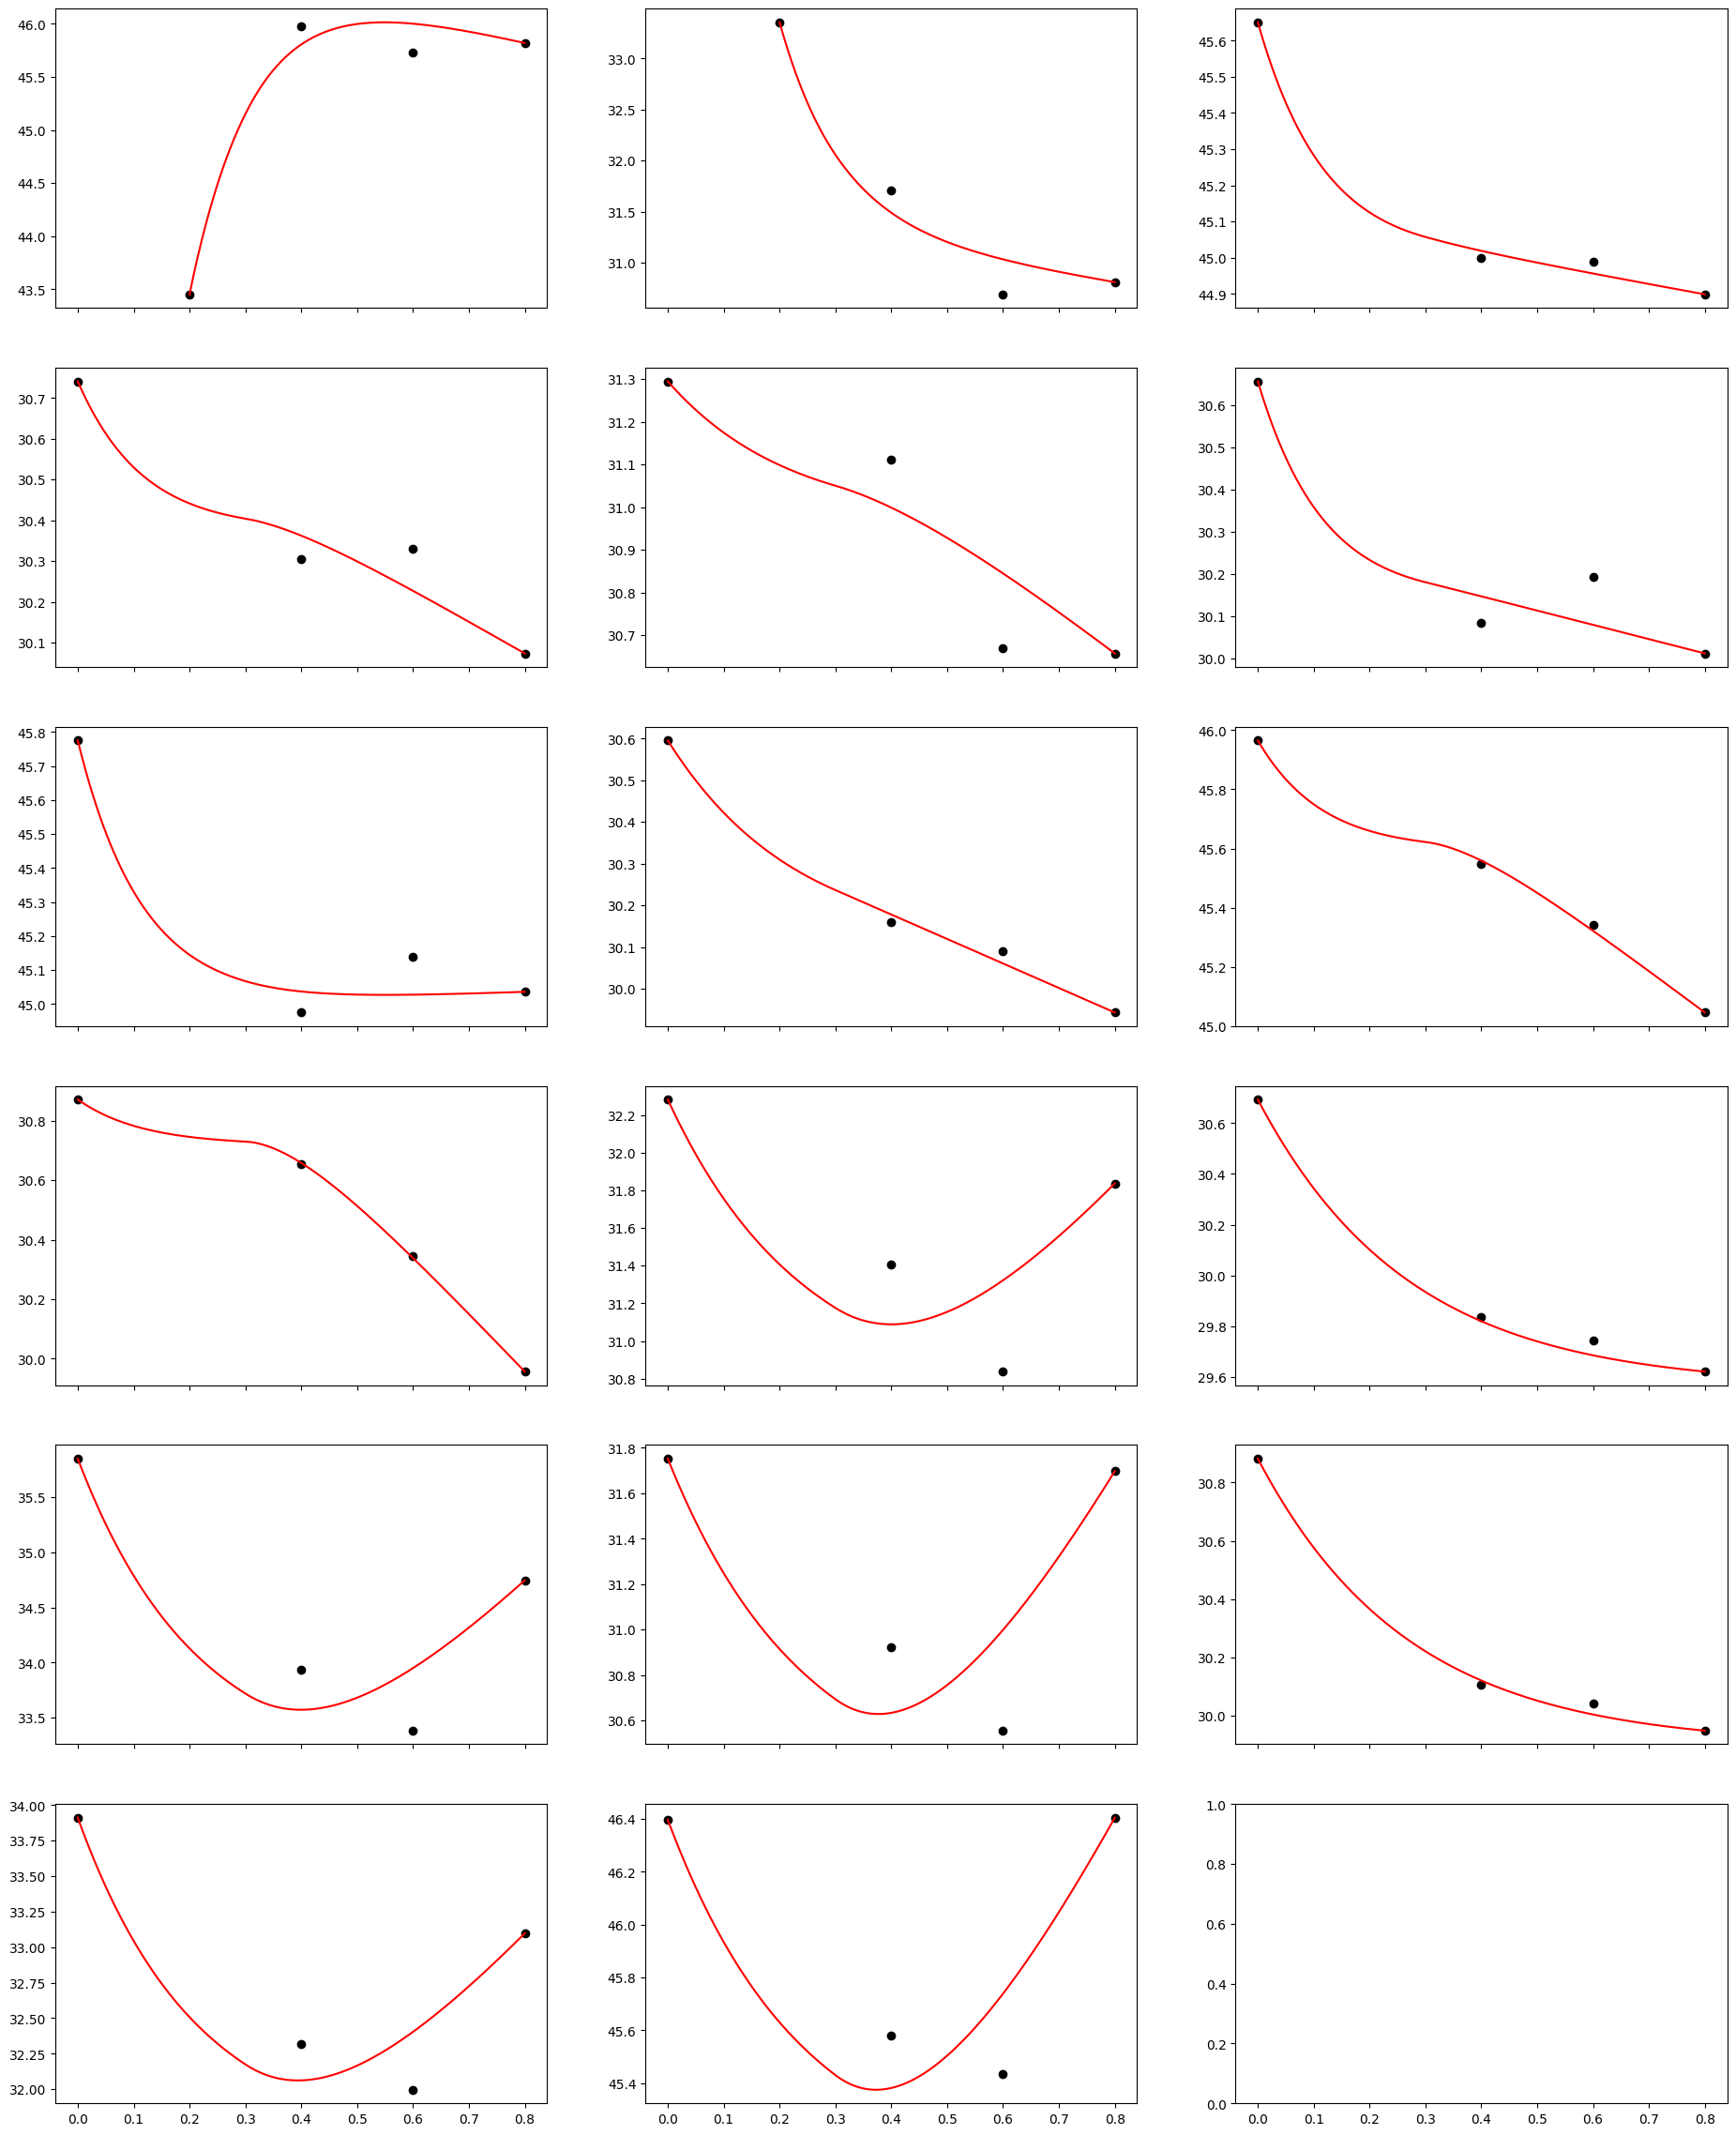

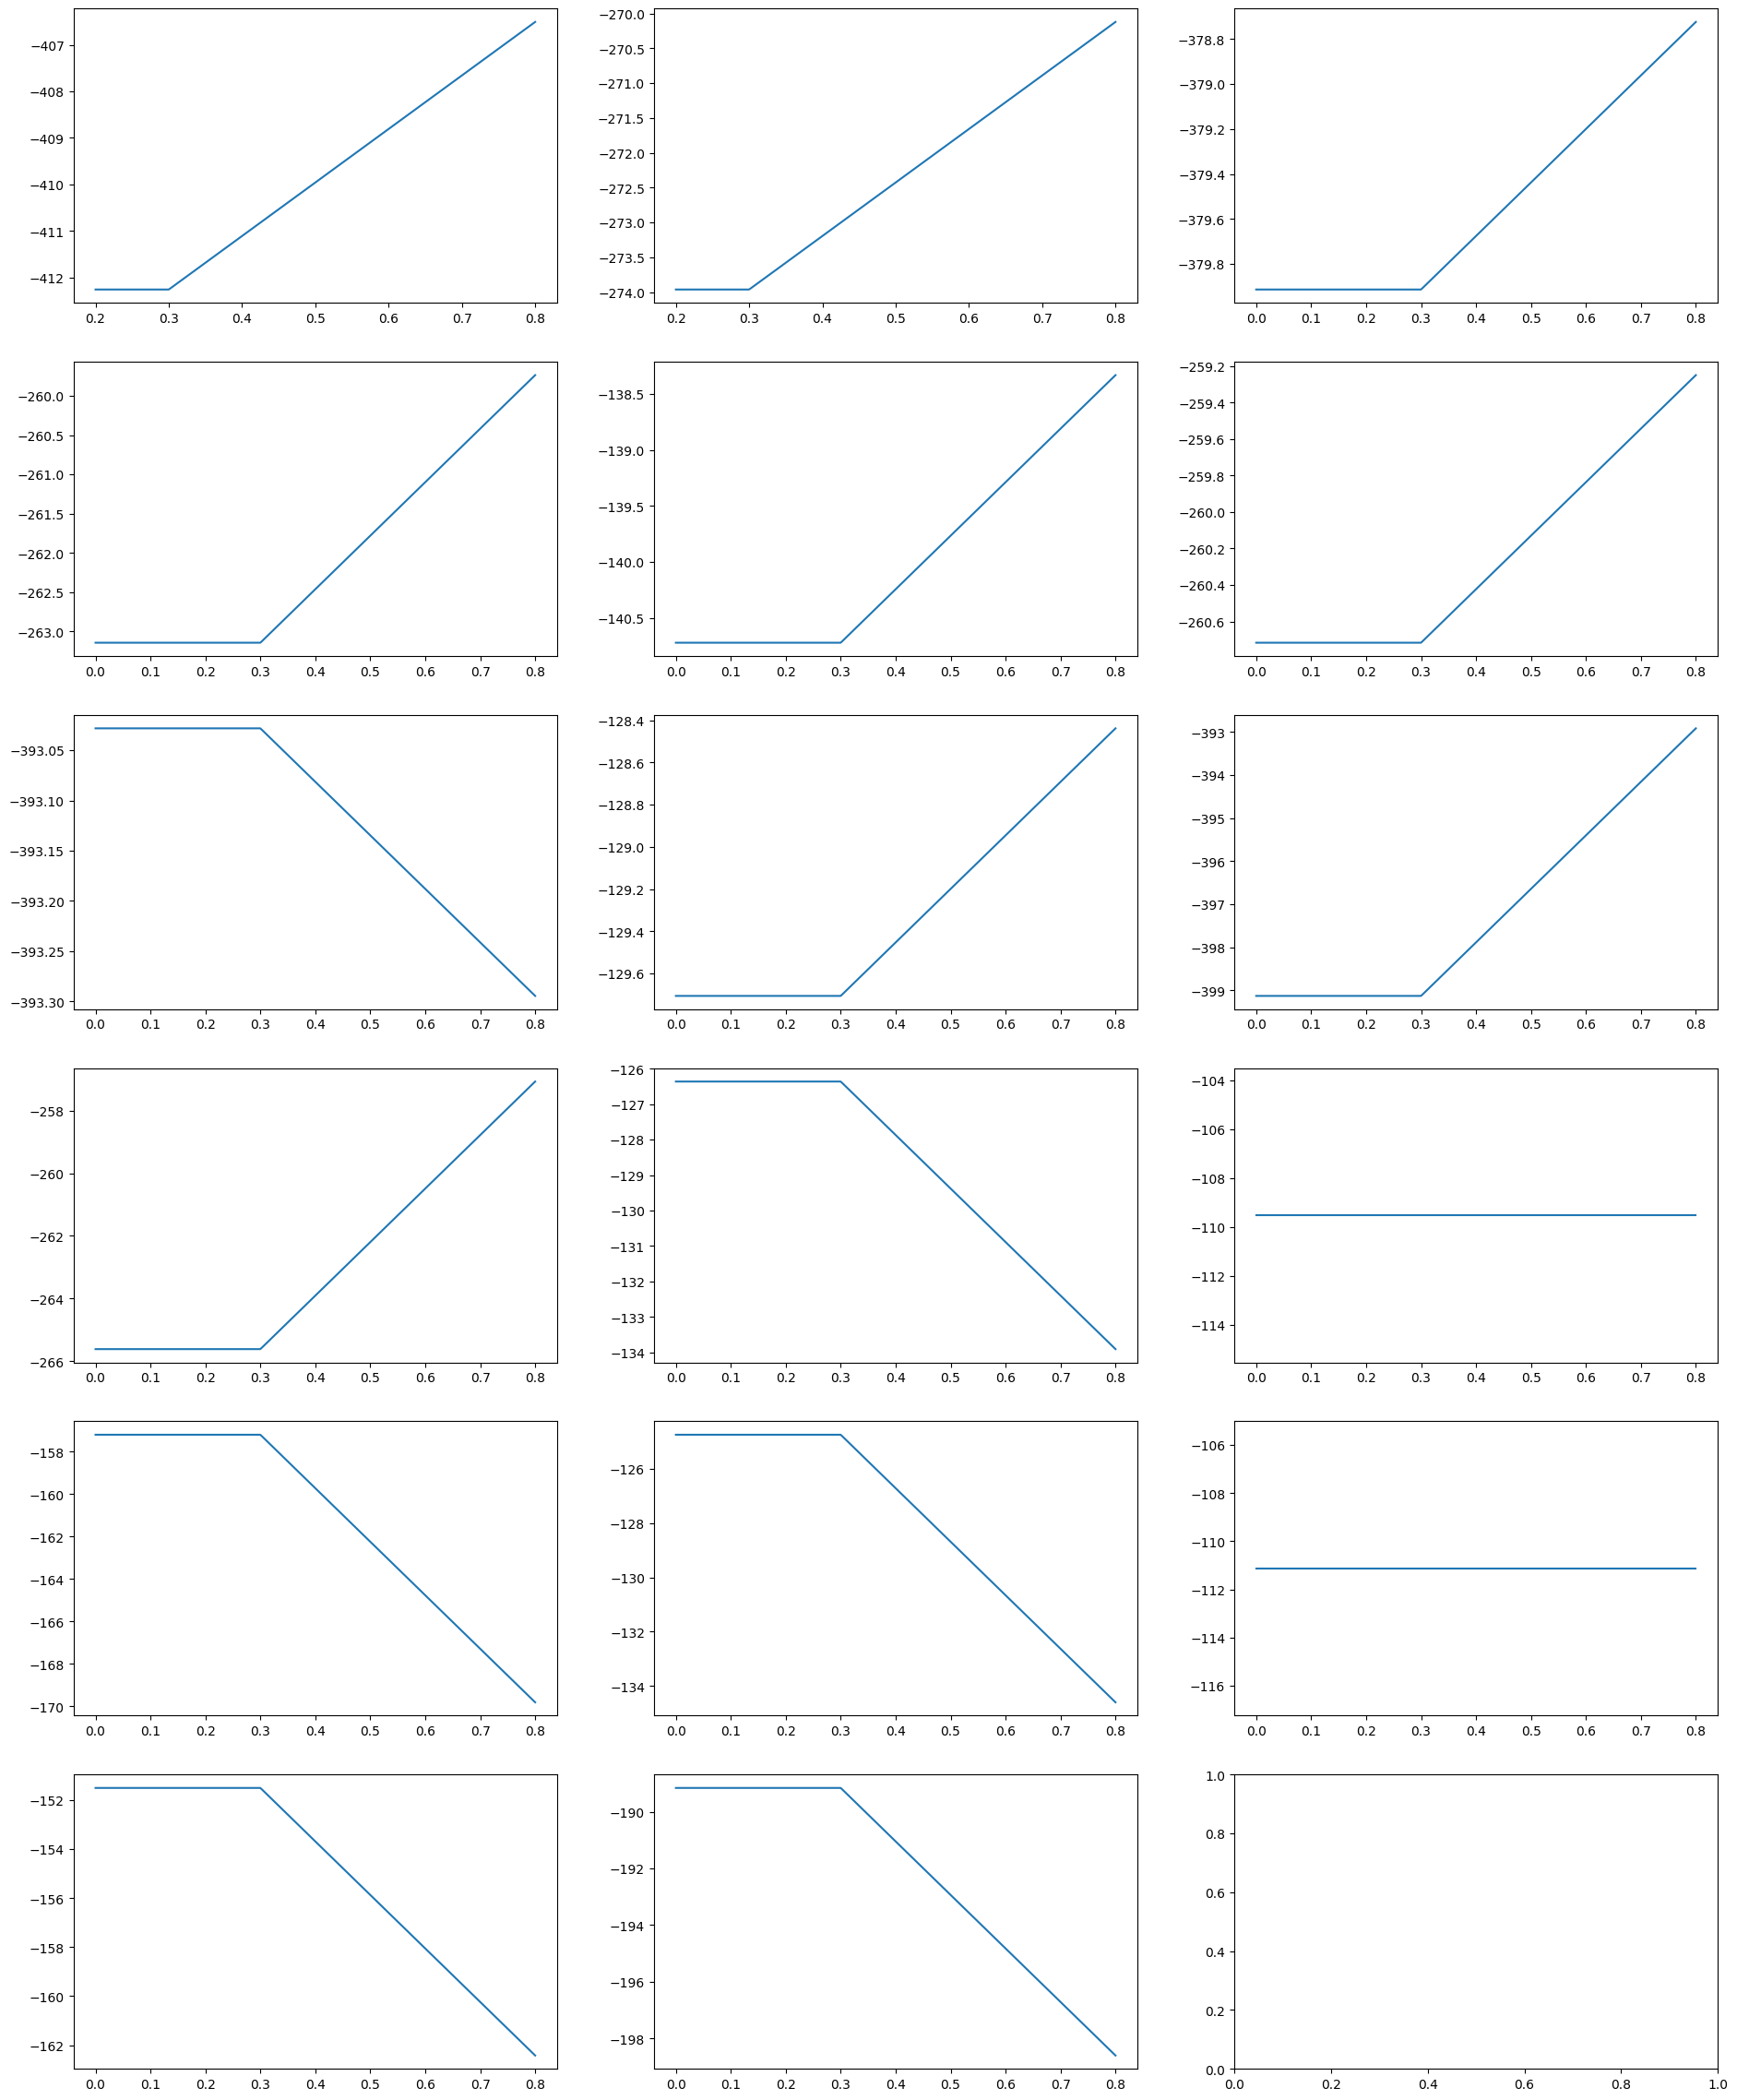

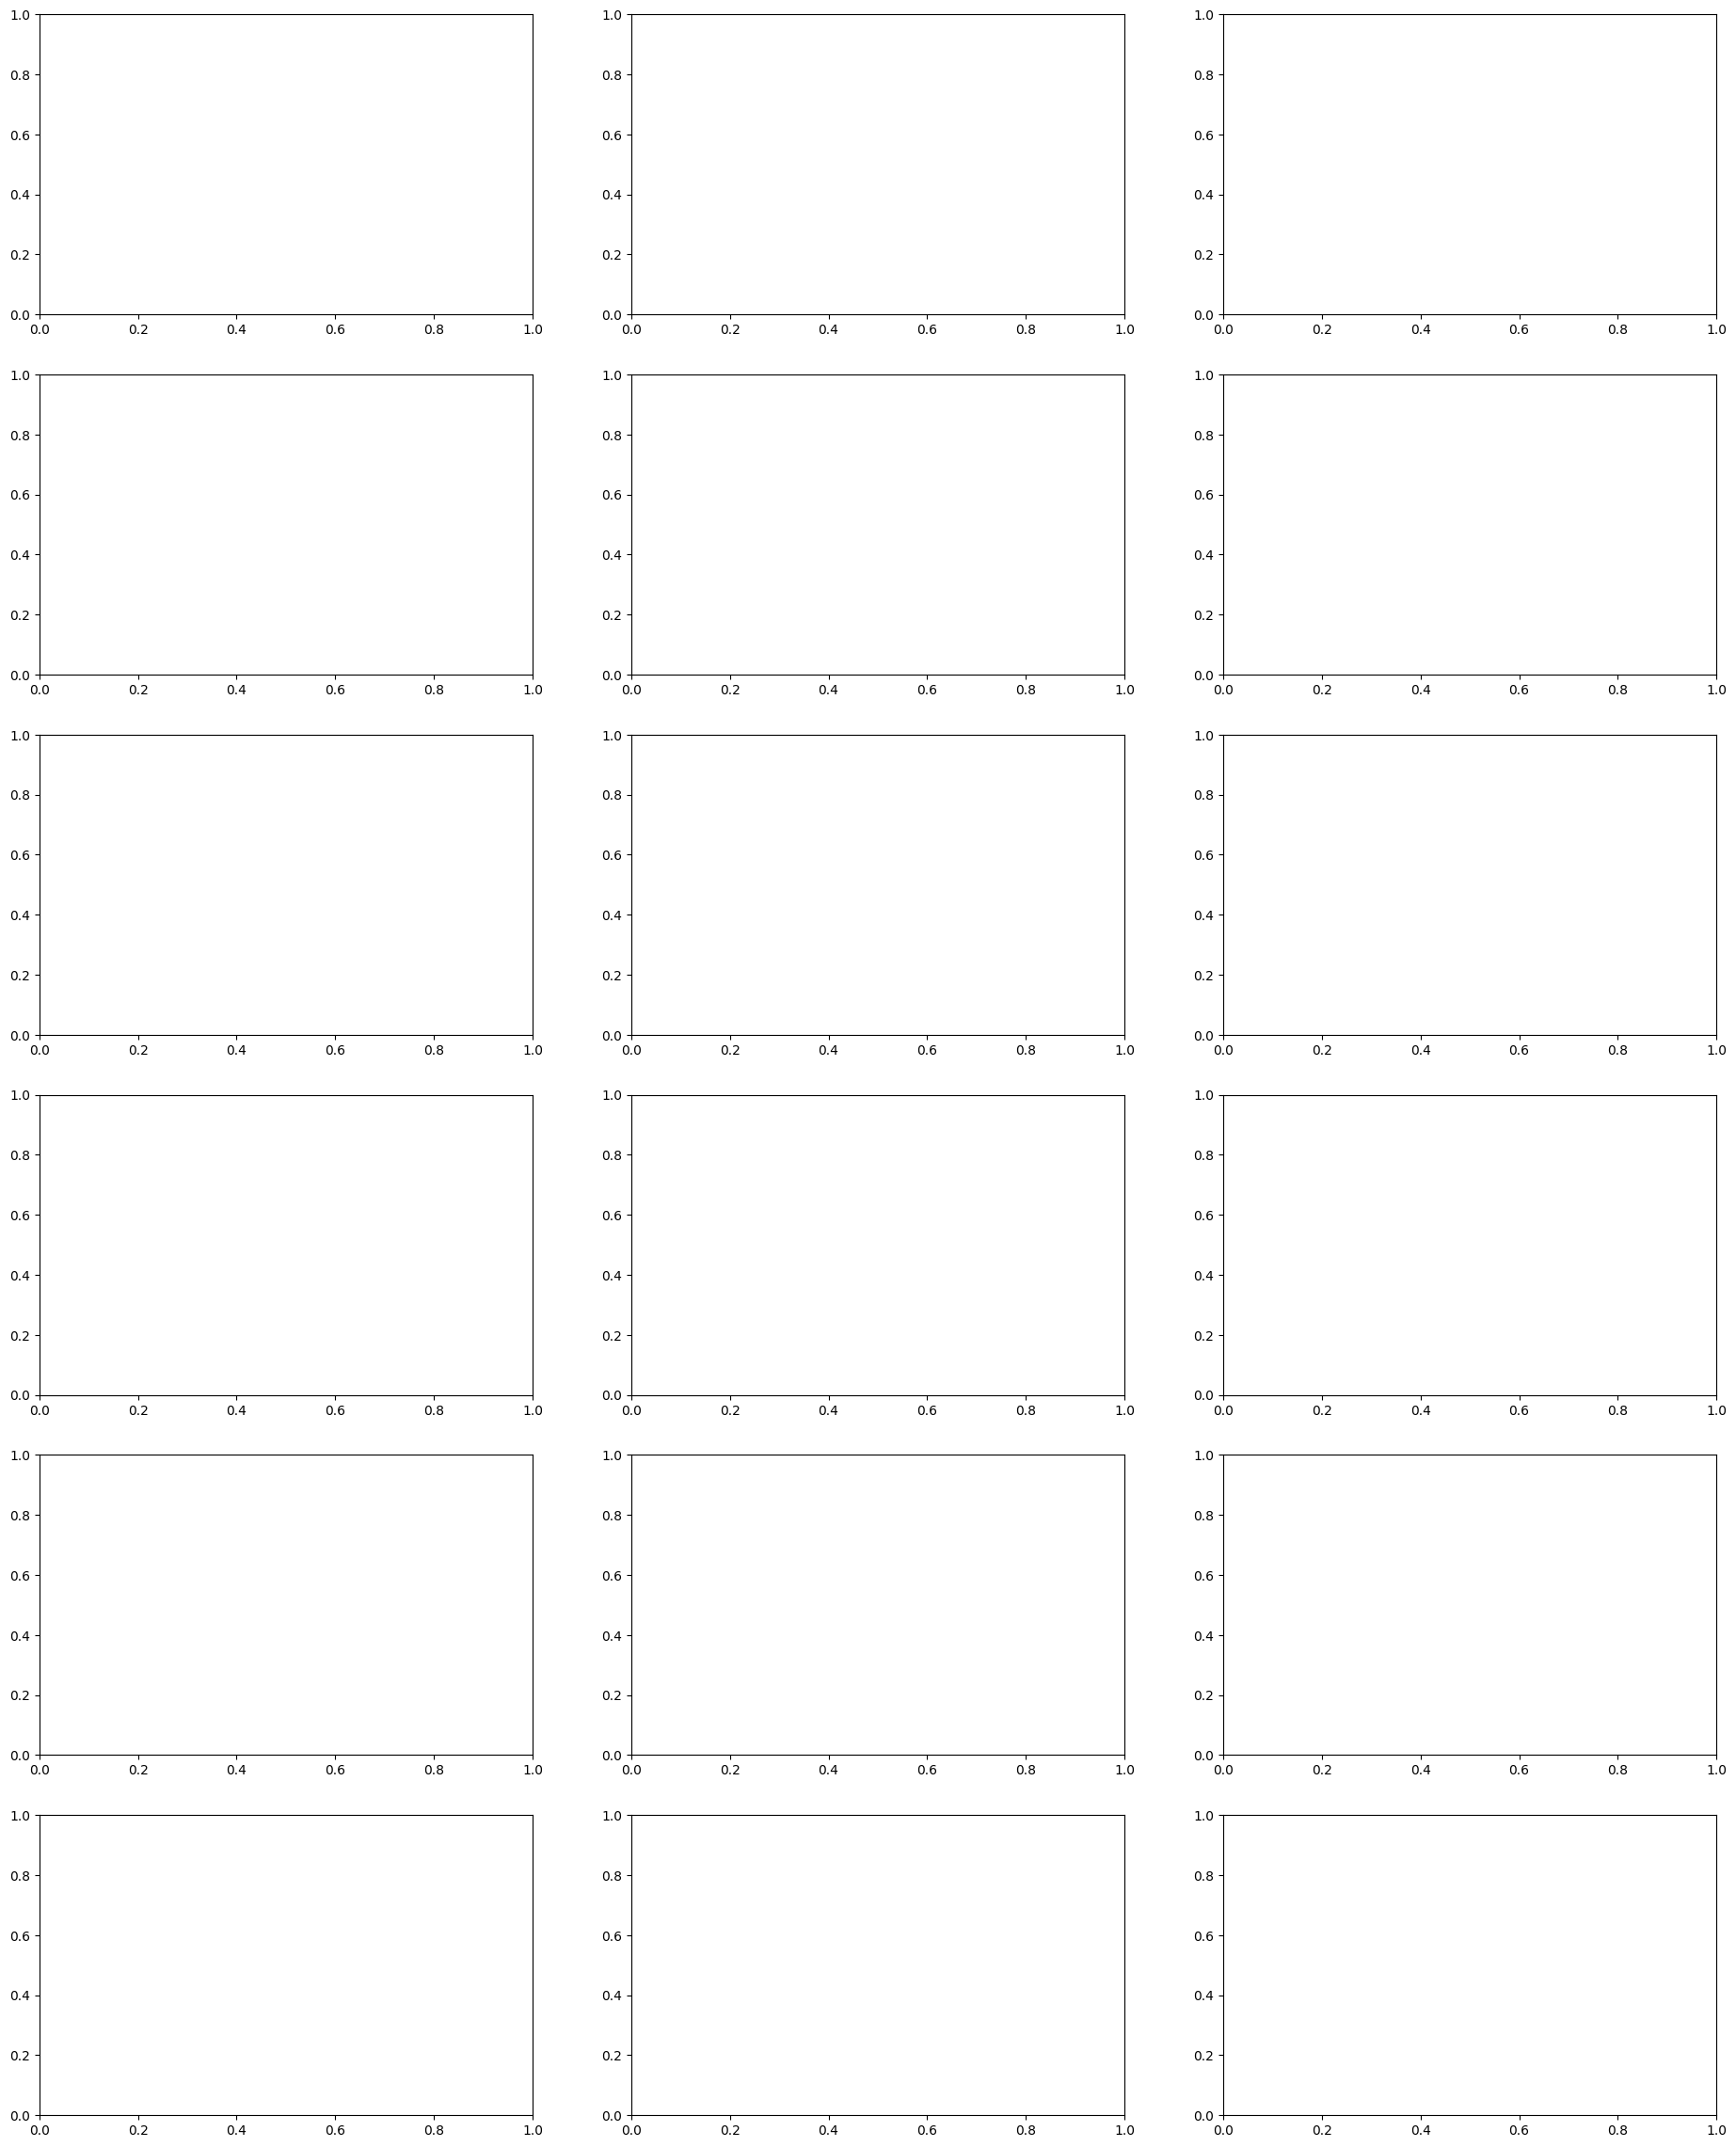

In [37]:
find_Q_eff_regions = [str(i) for i in range(1, num_regions + 1)]
count = 0
data_list = []
row, col = 6, 3
# figure_size = (40, 20)  # Adjusted figure size for better visibility
figure_size = (23, 29)  # Adjusted figure size for better visibility
fig, axes = plt.subplots(row, col, figsize=figure_size)
fig_z, axes_z = plt.subplots(row, col, figsize=figure_size, sharex='all')
fig_flux, axes_flux = plt.subplots(row, col, figsize=figure_size)
fig_Q, axes_Q = plt.subplots(row, col, figsize=figure_size)
for region in find_Q_eff_regions:
    df = pd.read_csv(rf"csv/df complete {region}.csv")
    note = note_dict.get(region)
    data = Data.from_df(df, note=note)
    data_list.append(data)
    
    xdata = array(list(product([data.v], data.z))).T
    ydata = data.yTs_mean
    # print(f"fit on xdata {xdata},\n ydata {ydata}")

    
    bc = [(data.z1, data.T1), (data.z2, data.T2)]
    bc_in_x = [(data.x1, data.T1), (data.x2, data.T2)]
    T_nonzero_params, T_nonzero_pcov, *args = scipy.optimize.curve_fit(
        lambda vz, T_heat_production_per_time: T_func(
            zdata=vz[1], 
            params = T_params(
                v=vz[0],
                chi=chi_eff,
                T_heat_production_per_time=T_heat_production_per_time,
                bc=bc,
                note=note,
            ),
        ),
        xdata,
        ydata,
        check_finite=True,
        full_output=True,
    )

    # unit: K/s
    T_heat_production_per_time = T_nonzero_params[0]

    if note == "no heat production":
        T_heat_production_per_time = 0.0

    # unit: W/m^3
    Q_eff_per_time = data.m * data.cp * T_heat_production_per_time
    Q_eff_per_time_per_V = data.rho * data.cp * T_heat_production_per_time

    Tps = T_params(
        v=data.v,
        chi=chi_eff,
        T_heat_production_per_time=T_heat_production_per_time,
        bc=bc,
        note=note,
    )

    idx = int(region) - 1
    zlinspace = linspace(data.z[0], data.z[-1], num)

    # plot normalized
    ax_z = axes_z[idx // col, idx % col]
    ax_z.plot(
        data.z,
        data.yTs_mean,
        "o",
        color="black",
        label=f"data mean\n{signif(data.yTs_mean)}",
    )
    ax_z.plot(
        zlinspace,
        T_func(zlinspace, Tps),
        label=f"fit\n{Tps.formula()}",
        color="red",
    )

    # plot unnormalized
    ax = axes[idx // col, idx % col]
    ax.violinplot(data.yTs.tolist(), positions=data.x)
    ax.plot(
        data.x,
        data.yTs_mean,
        "o",
        color="black",
        label=f"Mean temperature\n{signif(data.yTs_mean)}",
    )

    # plot flux
    ax_flux = axes_flux[idx // col, idx % col]
    ax_flux.plot(
        zlinspace,
        flux_func(zlinspace, Tps),
        "-",
        label=f"heat flux star",
    )

    # bc_in_x {signif(bc_in_x).tolist()}\n
# $m_{{liquid \ in \ pack}}$ = {signif(data.m)} kg
    label_quant_results = rf"""
$v = {signif(data.v)} \ m/s$
$Pe = {signif(Tps.Pe)}$
$\dot{{T}}_{{heat}} = {signif(T_heat_production_per_time)} \ K/s$
$\dot{{Q}}_{{heat}} = {signif(Q_eff_per_time)} \ W$
$\dot{{Q}}_{{heat}}$ per $1 \ m^3 = {signif(Q_eff_per_time_per_V/1000)} \ kW/m^3$
"""
    match note:
        case "remove process tank":
            xlabel = "x\n0 - Absorber process tank (excluded)\n1 - tank bottom\n2 - pack bottom\n3 - pack mid\n4 - pack top\n5 - gas outlet"
            title = f"Temperature in Region {region}\n({data.t_min} - {data.t_max})"
            label_quant_results += rf"""
$T^*_{{[0,\xi]}}(z) = {signif(Tps.C1)} + {signif(Tps.C2)} * e^{{{signif(Tps.Pe)} \cdot z}}$
$T^*_{{[\xi,1]}}(z) = {signif(Tps.C3)} + {signif(Tps.C4)} * e^{{{signif(Tps.Pe)} \cdot z}} + \frac{{{signif(Tps.S)}}}{{{signif(Tps.Pe)}}} \cdot z$
"""
            # index_slice = slice(num // 5, num)
            # index_slice = slice(0, num * 4 // 5)
        case "invalid tank bottom" | "no heat production":
            xlabel = "x\n0 - Absorber process tank\n1 - tank bottom (excluded)\n2 - pack bottom\n3 - pack mid\n4 - pack top\n5 - gas outlet"
            title = f"Temperature in Region {region}\n({data.t_min} - {data.t_max})"
            # index_slice = slice(0, num)
            if note == "no heat production":
                title = f"Temperature in Region {region}\n({data.t_min} - {data.t_max}) (no heat production)"
                label_quant_results += rf"""
$T^*_{{[0,1]}}(z) = {signif(Tps.C1)} + {signif(Tps.C2)} * e^{{{signif(Tps.Pe)} \cdot z}}$
"""
            else:
                label_quant_results += rf"""
$T^*_{{[0,\xi]}}(z) = {signif(Tps.C1)} + {signif(Tps.C2)} * e^{{{signif(Tps.Pe)} \cdot z}}$
$T^*_{{[\xi,1]}}(z) = {signif(Tps.C3)} + {signif(Tps.C4)} * e^{{{signif(Tps.Pe)} \cdot z}} + \frac{{{signif(Tps.S)}}}{{{signif(Tps.Pe)}}} \cdot z$
"""


        case _:
            raise ValueError(f"Invalid note: {note}")
    label = f"{label_quant_results}"
    # print(label_quant_results)
    ax.plot(
        zlinspace * 5,
        T_func(
            zlinspace,
            Tps,
        ),
        label=label # + f"\n{Tps.formula()}",
    )
    ax.set_xlabel("z")
    ax.set_ylabel("Temperature [°C]")
    ax.legend(bbox_to_anchor=(1, 0.5), loc="center left")
    ax.set_xticks(array([0, 1, 2, 3, 4, 5]))
    ax.set_xlabel(xlabel, loc="left")
    ax.set_title(title)
    # ax.set_xlim(0,1)
    if Q_eff_per_time< 0:
        print(region, signif(Q_eff_per_time))

    # print(Tps.formula())

suptitle = rf"Temperature profile (2 ODEs, interface at point 1.5)"
fig.suptitle(suptitle + rf" $\chi_{{eff}}$ = {signif(chi_eff)} $m^2/s$", fontsize=20)
fig.tight_layout(pad=2.0)
fig.savefig(f"{suptitle}.pdf")
fig.savefig(f"{suptitle}.svg", bbox_inches="tight")
# fig_z.savefig("new17plots_z.png")
# fig.savefig("newplots.svg")

data_list_to_df_verbose(data_list)   #.to_csv("data_summary.csv")


16 -2170.0


,t_min,t_max,flow_rate_from_absorber,flow_rate_to_absorber,x1,x2,z1,z2,T1,T2,...,L,r_pack,h_pack,rho,cp,porosity,yTs,yTs_mean,x,z
0,2024-05-27 17:00:17,2024-05-28 08:19:44,9.379462,8.695371,0,4,0.0,0.8,33.911828,33.097223,...,3.5,0.18,2,997,4184,0.97,"[[43.928077, 43.666322, 43.853511, 43.816485, ...","[43.453275967601016, 45.97922044521296, 45.726...","[1, 2, 3, 4]","[0.2, 0.4, 0.6, 0.8]"
1,2024-06-25 23:05:10,2024-06-26 08:19:56,4.542637,4.315505,0,4,0.0,0.8,33.911828,33.097223,...,3.5,0.18,2,997,4184,0.97,"[[30.574375, 30.574375, 30.574375, 30.594629, ...","[30.595422960217, 30.15945788426763, 30.089042...","[0, 2, 3, 4]","[0.0, 0.4, 0.6, 0.8]"
2,2025-03-06 14:00:10,2025-03-06 15:14:55,5.048897,3.762148,0,4,0.0,0.8,33.911828,33.097223,...,3.5,0.18,2,997,4184,0.97,"[[34.244194, 34.233784, 34.224239, 34.213531, ...","[33.911828360730595, 32.32058079452055, 31.995...","[0, 2, 3, 4]","[0.0, 0.4, 0.6, 0.8]"


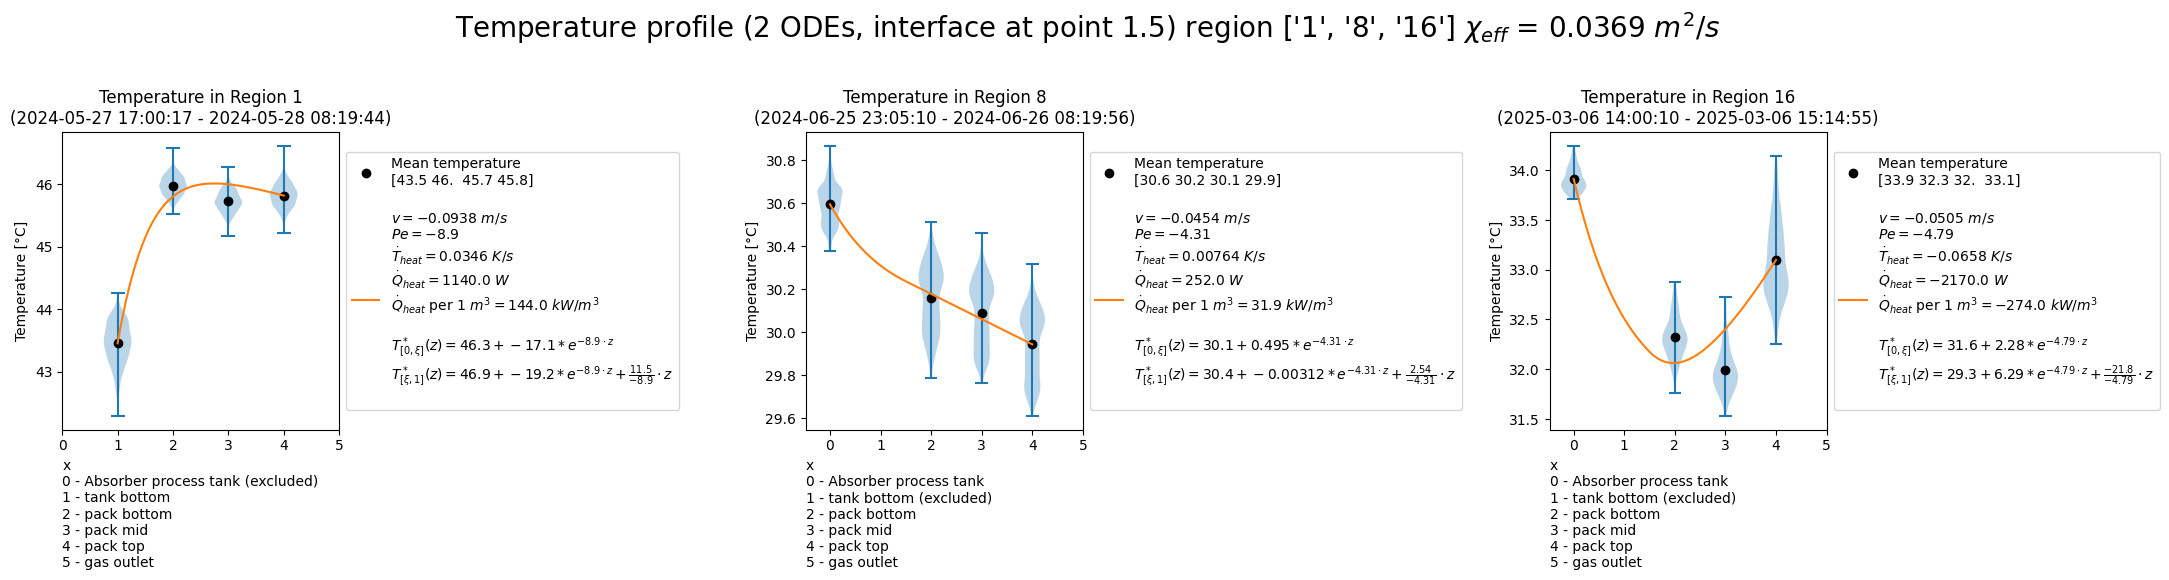

In [36]:
find_Q_eff_regions = ["1","8","16"]
count = 0
data_list = []
row, col = 1, 3
# figure_size = (40, 20)  # Adjusted figure size for better visibility
figure_size = (22,6)  # Adjusted figure size for better visibility
fig, axes = plt.subplots(row, col, figsize=figure_size)
idx = 0
for region in find_Q_eff_regions:
    df = pd.read_csv(rf"csv/df complete {region}.csv")
    note = note_dict.get(region)
    data = Data.from_df(df, note=note)
    data_list.append(data)
    
    xdata = array(list(product([data.v], data.z))).T
    ydata = data.yTs_mean
    # print(f"fit on xdata {xdata},\n ydata {ydata}")

    
    bc = [(data.z1, data.T1), (data.z2, data.T2)]
    bc_in_x = [(data.x1, data.T1), (data.x2, data.T2)]
    T_nonzero_params, T_nonzero_pcov, *args = scipy.optimize.curve_fit(
        lambda vz, T_heat_production_per_time: T_func(
            zdata=vz[1], 
            params = T_params(
                v=vz[0],
                chi=chi_eff,
                T_heat_production_per_time=T_heat_production_per_time,
                bc=bc,
                note=note,
            ),
        ),
        xdata,
        ydata,
        check_finite=True,
        full_output=True,
    )

    # unit: K/s
    T_heat_production_per_time = T_nonzero_params[0]

    if note == "no heat production":
        T_heat_production_per_time = 0.0

    # unit: W/m^3
    Q_eff_per_time = data.m * data.cp * T_heat_production_per_time
    Q_eff_per_time_per_V = data.rho * data.cp * T_heat_production_per_time

    Tps = T_params(
        v=data.v,
        chi=chi_eff,
        T_heat_production_per_time=T_heat_production_per_time,
        bc=bc,
        note=note,
    )

    zlinspace = linspace(data.z[0], data.z[-1], num)

    # plot unnormalized
    ax = axes[idx]
    ax.violinplot(data.yTs.tolist(), positions=data.x)
    ax.plot(
        data.x,
        data.yTs_mean,
        "o",
        color="black",
        label=f"Mean temperature\n{signif(data.yTs_mean)}",
    )

    # bc_in_x {signif(bc_in_x).tolist()}\n
# $m_{{liquid \ in \ pack}}$ = {signif(data.m)} kg
    label_quant_results = rf"""
$v = {signif(data.v)} \ m/s$
$Pe = {signif(Tps.Pe)}$
$\dot{{T}}_{{heat}} = {signif(T_heat_production_per_time)} \ K/s$
$\dot{{Q}}_{{heat}} = {signif(Q_eff_per_time)} \ W$
$\dot{{Q}}_{{heat}}$ per $1 \ m^3 = {signif(Q_eff_per_time_per_V/1000)} \ kW/m^3$
"""
    match note:
        case "remove process tank":
            xlabel = "x\n0 - Absorber process tank (excluded)\n1 - tank bottom\n2 - pack bottom\n3 - pack mid\n4 - pack top\n5 - gas outlet"
            title = f"Temperature in Region {region}\n({data.t_min} - {data.t_max})"
            label_quant_results += rf"""
$T^*_{{[0,\xi]}}(z) = {signif(Tps.C1)} + {signif(Tps.C2)} * e^{{{signif(Tps.Pe)} \cdot z}}$
$T^*_{{[\xi,1]}}(z) = {signif(Tps.C3)} + {signif(Tps.C4)} * e^{{{signif(Tps.Pe)} \cdot z}} + \frac{{{signif(Tps.S)}}}{{{signif(Tps.Pe)}}} \cdot z$
"""
            # index_slice = slice(num // 5, num)
            # index_slice = slice(0, num * 4 // 5)
        case "invalid tank bottom" | "no heat production":
            xlabel = "x\n0 - Absorber process tank\n1 - tank bottom (excluded)\n2 - pack bottom\n3 - pack mid\n4 - pack top\n5 - gas outlet"
            title = f"Temperature in Region {region}\n({data.t_min} - {data.t_max})"
            # index_slice = slice(0, num)
            if note == "no heat production":
                title = f"Temperature in Region {region}\n({data.t_min} - {data.t_max}) (no heat production)"
                label_quant_results += rf"""
$T^*_{{[0,1]}}(z) = {signif(Tps.C1)} + {signif(Tps.C2)} * e^{{{signif(Tps.Pe)} \cdot z}}$
"""
            else:
                label_quant_results += rf"""
$T^*_{{[0,\xi]}}(z) = {signif(Tps.C1)} + {signif(Tps.C2)} * e^{{{signif(Tps.Pe)} \cdot z}}$
$T^*_{{[\xi,1]}}(z) = {signif(Tps.C3)} + {signif(Tps.C4)} * e^{{{signif(Tps.Pe)} \cdot z}} + \frac{{{signif(Tps.S)}}}{{{signif(Tps.Pe)}}} \cdot z$
"""


        case _:
            raise ValueError(f"Invalid note: {note}")
    label = f"{label_quant_results}"
    # print(label_quant_results)
    ax.plot(
        zlinspace * 5,
        T_func(
            zlinspace,
            Tps,
        ),
        label=label # + f"\n{Tps.formula()}",
    )
    ax.set_xlabel("z")
    ax.set_ylabel("Temperature [°C]")
    ax.legend(bbox_to_anchor=(1, 0.5), loc="center left")
    ax.set_xticks(array([0, 1, 2, 3, 4, 5]))
    ax.set_xlabel(xlabel, loc="left")
    ax.set_title(title)
    # ax.set_xlim(0,1)
    if Q_eff_per_time< 0:
        print(region, signif(Q_eff_per_time))

    # print(Tps.formula())
    idx += 1

suptitle = rf"Temperature profile (2 ODEs, interface at point 1.5) region {find_Q_eff_regions}"
fig.suptitle(suptitle + rf" $\chi_{{eff}}$ = {signif(chi_eff)} $m^2/s$", fontsize=20)
fig.tight_layout(pad=2.0)
fig.savefig(f"{suptitle}.pdf")
fig.savefig(f"{suptitle}.svg", bbox_inches="tight")
# fig_z.savefig("new17plots_z.png")
# fig.savefig("newplots.svg")

data_list_to_df_verbose(data_list)   #.to_csv("data_summary.csv")
